In [205]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)
from torch.autograd import Variable

In [109]:
from torchvision.models import *

In [110]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 

In [111]:
import os
import uuid
import shutil
import json
import copy
from datetime import datetime

In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cuda:0


In [113]:
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

In [114]:
transform = transforms.Compose([transforms.ToTensor(),
                                # expand chennel from 1 to 3 to fit 
                                # ResNet pretrained model
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                ])

In [115]:
train_set = FashionMNIST(root='./data', train=True, download=False, transform=transform)
val_set = FashionMNIST(root='./data', train=False, download=False, transform=transform)

In [116]:
test_size = int(0.5 * len(val_set))
test_set, val_set = random_split(val_set, [test_size, len(val_set) - test_size])

In [181]:
# define hyperparameters
batch_size = 256
num_epochs = 20
learning_rate = 1e-6
momentum=0.9
# learning rate scheduler
lr_scheduler=True
base_lr=0.001
max_lr=0.01

In [229]:
# define the function to train the model
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
        # Loop through the data in loader
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            
            train = Variable(x)
            labels = Variable(y)
            z = model(train)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

In [230]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [243]:
model = models.resnet18()
for param in model.parameters():
       param.requires_grad = True
model.fc = nn.Linear(512, 10)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [244]:
criterion = nn.CrossEntropyLoss()

In [245]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

In [246]:
batch = next(iter(train_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([128, 3, 28, 28]) torch.Size([128])


In [247]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=3e-4, max_lr=0.01,step_size_up=5,mode="triangular2")

In [248]:
start_datetime = datetime.now()
start_time = time.time()

accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader=val_loader, criterion=criterion, optimizer=optimizer, n_epochs=num_epochs,print_=True)

endtime = time.time()
total_time = endtime - start_time
print("total time:", total_time)

The first epoch should take several minutes


  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 done


  5%|▌         | 1/20 [00:42<13:32, 42.75s/it]

learning rate 0.002240000000000002
The validaion  Cost for each epoch 1: 0.6768411516126539
The validation accuracy for epoch 1: 0.8342
epoch 1 done


 10%|█         | 2/20 [01:27<13:10, 43.90s/it]

learning rate 0.00418
The validaion  Cost for each epoch 2: 0.4710794150638682
The validation accuracy for epoch 2: 0.8506
epoch 2 done


 15%|█▌        | 3/20 [02:09<12:09, 42.94s/it]

learning rate 0.006120000000000001
The validaion  Cost for each epoch 3: 0.36940463481427255
The validation accuracy for epoch 3: 0.8292
epoch 3 done


 20%|██        | 4/20 [02:52<11:31, 43.20s/it]

learning rate 0.00806
The validaion  Cost for each epoch 4: 0.3204975990789023
The validation accuracy for epoch 4: 0.8848
epoch 4 done


 25%|██▌       | 5/20 [03:35<10:46, 43.13s/it]

learning rate 0.01
The validaion  Cost for each epoch 5: 0.29082275193129015
The validation accuracy for epoch 5: 0.8756
epoch 5 done


 30%|███       | 6/20 [04:18<10:02, 43.06s/it]

learning rate 0.00806
The validaion  Cost for each epoch 6: 0.2681577854605118
The validation accuracy for epoch 6: 0.8802
epoch 6 done


 35%|███▌      | 7/20 [04:58<09:04, 41.88s/it]

learning rate 0.006120000000000001
The validaion  Cost for each epoch 7: 0.2338373095972706
The validation accuracy for epoch 7: 0.8908
epoch 7 done


 40%|████      | 8/20 [05:37<08:14, 41.17s/it]

learning rate 0.00418
The validaion  Cost for each epoch 8: 0.2030247101016136
The validation accuracy for epoch 8: 0.8932
epoch 8 done


 45%|████▌     | 9/20 [06:20<07:38, 41.64s/it]

learning rate 0.002240000000000002
The validaion  Cost for each epoch 9: 0.17190423539516006
The validation accuracy for epoch 9: 0.902
epoch 9 done


 50%|█████     | 10/20 [07:01<06:53, 41.39s/it]

learning rate 0.0003
The validaion  Cost for each epoch 10: 0.13405630128311197
The validation accuracy for epoch 10: 0.906
epoch 10 done


 55%|█████▌    | 11/20 [07:40<06:06, 40.75s/it]

learning rate 0.001270000000000001
The validaion  Cost for each epoch 11: 0.09278008882710928
The validation accuracy for epoch 11: 0.9086
epoch 11 done


 60%|██████    | 12/20 [08:20<05:22, 40.36s/it]

learning rate 0.002240000000000002
The validaion  Cost for each epoch 12: 0.09350097825579932
The validation accuracy for epoch 12: 0.9078
epoch 12 done


 65%|██████▌   | 13/20 [08:59<04:40, 40.14s/it]

learning rate 0.0032099999999999984
The validaion  Cost for each epoch 13: 0.09885667438414306
The validation accuracy for epoch 13: 0.9004
epoch 13 done


 70%|███████   | 14/20 [09:40<04:02, 40.39s/it]

learning rate 0.00418
The validaion  Cost for each epoch 14: 0.11121080138647099
The validation accuracy for epoch 14: 0.8982
epoch 14 done


 75%|███████▌  | 15/20 [10:20<03:20, 40.12s/it]

learning rate 0.00515
The validaion  Cost for each epoch 15: 0.12294609860173547
The validation accuracy for epoch 15: 0.8974
epoch 15 done


 80%|████████  | 16/20 [10:59<02:39, 39.88s/it]

learning rate 0.00418
The validaion  Cost for each epoch 16: 0.12629209255883053
The validation accuracy for epoch 16: 0.9006
epoch 16 done


 85%|████████▌ | 17/20 [11:38<01:59, 39.71s/it]

learning rate 0.0032099999999999984
The validaion  Cost for each epoch 17: 0.10117777127192727
The validation accuracy for epoch 17: 0.9004
epoch 17 done


 90%|█████████ | 18/20 [12:19<01:19, 39.96s/it]

learning rate 0.002240000000000002
The validaion  Cost for each epoch 18: 0.07319151037044998
The validation accuracy for epoch 18: 0.8996
epoch 18 done


 95%|█████████▌| 19/20 [13:02<00:40, 40.77s/it]

learning rate 0.001270000000000001
The validaion  Cost for each epoch 19: 0.04592408403865437
The validation accuracy for epoch 19: 0.9026
epoch 19 done


100%|██████████| 20/20 [13:44<00:00, 41.24s/it]

learning rate 0.0003
The validaion  Cost for each epoch 20: 0.021730779676632617
The validation accuracy for epoch 20: 0.9098
total time: 824.8619422912598


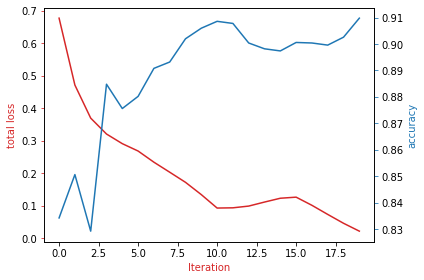

In [249]:
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

plot_stuff(loss_list,accuracy_list)

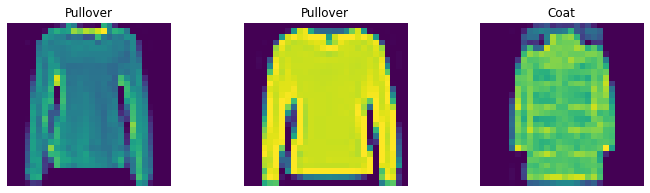

: 

In [267]:
# show the first three images in the validation daaset and the predicted label
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
for i in range(3):
    axs[i].imshow(val_set[i][0][0].numpy())
    axs[i].set_title(output_label(val_set[i][1]))
    axs[i].axis('off')